# 03 — Unsupervised Learning Methods

In [15]:
# ============================================================
# BLOK 0: DRIVE + PATH SETUP (Fixed paths for your Drive)
# Amaç:
# - Veriyi Drive'dan okumak
# - Figürleri ve tabloları Drive'a kaydetmek
# ============================================================

from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path

BASE_DIR  = Path("/content/drive/MyDrive/Student-Stress-Academic-Performance")
MODEL_DIR = BASE_DIR / "models"
DATA_PATH = BASE_DIR / "processed_student_mental_health.csv"
FIG_DIR   = BASE_DIR / "outputs" / "figures"
TAB_DIR   = BASE_DIR / "outputs" / "tables"

# Klasörleri oluştur
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

print("BASE_DIR :", BASE_DIR)
print("MODEL_DIR:", MODEL_DIR)
print("DATA_PATH:", DATA_PATH)
print("FIG_DIR  :", FIG_DIR)
print("TAB_DIR  :", TAB_DIR)

# Dosya kontrolü
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Processed CSV bulunamadı: {DATA_PATH}\n"
        "Lütfen dosyanın gerçekten bu konumda olduğundan emin ol."
    )


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_DIR : /content/drive/MyDrive/Student-Stress-Academic-Performance
MODEL_DIR: /content/drive/MyDrive/Student-Stress-Academic-Performance/models
DATA_PATH: /content/drive/MyDrive/Student-Stress-Academic-Performance/processed_student_mental_health.csv
FIG_DIR  : /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/figures
TAB_DIR  : /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables


In [12]:
# ============================================================
# Setup: Load processed dataset created in 01_Design_EDA.ipynb
# ============================================================

import os
import pandas as pd
import numpy as np

PROCESSED_DATA_PATH = "/content/drive/MyDrive/Student-Stress-Academic-Performance/processed_student_mental_health.csv"

if not os.path.exists(PROCESSED_DATA_PATH):
    raise FileNotFoundError(
        f"Processed file not found: {PROCESSED_DATA_PATH}. "
        "Please run 01_Design_EDA.ipynb first."
    )

df = pd.read_csv(PROCESSED_DATA_PATH)
df.head()


,Timestamp,Choose your gender,Age,What is your course?,Your current year of Study,What is your CGPA?,Marital status,Do you have Depression?,Do you have Anxiety?,Do you have Panic attack?,Did you seek any specialist for a treatment?,depression_bin,anxiety_bin,panic_bin,treatment_bin,stress_score,high_stress_no_treatment,high_cgpa,cgpa_clean
0,8/7/2020 12:02,Female,18.0,Engineering,year 1,3.00-3.49,No,Yes,No,Yes,No,1,0,1,0,2,1,0,3.00-3.49
1,8/7/2020 12:04,Male,21.0,Islamic education,year 2,3.00-3.49,No,No,Yes,No,No,0,1,0,0,1,0,0,3.00-3.49
2,8/7/2020 12:05,Male,19.0,BIT,Year 1,3.00-3.49,No,Yes,Yes,Yes,No,1,1,1,0,3,1,0,3.00-3.49
3,8/7/2020 12:06,Female,22.0,Laws,year 3,3.00-3.49,Yes,Yes,No,No,No,1,0,0,0,1,0,0,3.00-3.49
4,8/7/2020 12:13,Male,23.0,Mathemathics,year 4,3.00-3.49,No,No,No,No,No,0,0,0,0,0,0,0,3.00-3.49


In [13]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/content/drive/MyDrive/Student-Stress-Academic-Performance/processed_student_mental_health.csv")

unsup_features = ["stress_score", "depression_bin", "anxiety_bin", "panic_bin"]
X_unsup = df[unsup_features].copy()

print("X_unsup shape:", X_unsup.shape)
X_unsup.head()

scaler_unsup = StandardScaler()
X_scaled = scaler_unsup.fit_transform(X_unsup)

print("Scaled shape:", X_scaled.shape)


joblib.dump(scaler_unsup, "/content/drive/MyDrive/Student-Stress-Academic-Performance/models/scaler_unsup.joblib")


X_unsup shape: (101, 4)
Scaled shape: (101, 4)


['/content/drive/MyDrive/Student-Stress-Academic-Performance/models/scaler_unsup.joblib']

In [14]:
# ============================================================
# BLOK 16: COMMON PREPARATION FOR UNSUPERVISED METHODS
# Amaç:
# - Unsupervised learning (clustering) için ortak altyapıyı hazırlamak
# - Tüm yöntemlerde (K-Means, Hierarchical, DBSCAN)
#   aynı feature setini kullanarak adil karşılaştırma sağlamak
# - Distance-based algoritmalar için standardization uygulamak
# ============================================================

# Gerekli kütüphaneler
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# ------------------------------------------------------------
# 1) Clustering için kullanılacak feature'ların seçilmesi
# Neden bu feature'lar?
# - stress_score: türetilmiş genel stres seviyesi
# - depression_bin, anxiety_bin, panic_bin:
#   öğrencinin psikolojik durumunu temsil eden binary göstergeler
# Akademik performans (high_cgpa) bilinçli olarak KULLANILMIYOR
# çünkü unsupervised learning etiket bilgisi içermez.
# ------------------------------------------------------------

cluster_features = [
    "stress_score",
    "depression_bin",
    "anxiety_bin",
    "panic_bin"
]

# Feature setini ayır
X_cluster = df[cluster_features]

# Kontrol: ilk birkaç satırı incele
print("Selected features for clustering:")
print(X_cluster.head())

# ------------------------------------------------------------
# 2) Standardization (Ölçekleme)
# Neden gerekli?
# - K-Means, Hierarchical ve DBSCAN mesafeye dayalı algoritmalardır
# - Farklı ölçeklerdeki değişkenler (0-3, 0-1 gibi)
#   mesafe hesaplarını bozabilir
# - StandardScaler: her feature'ı ortalaması 0, std'si 1 olacak şekilde dönüştürür
# ------------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Standardization sonrası kontrol
X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=cluster_features
)

print("\nStandardized feature summary:")
print(X_scaled_df.describe())

# ------------------------------------------------------------
# 3) Bu noktadan sonra:
# - X_scaled → K-Means, Hierarchical ve DBSCAN için kullanılacak
# - Silhouette Score hesaplamaları da bu ölçeklenmiş veri üzerinden yapılacak
# ------------------------------------------------------------

print("\nBLOK 16 completed: Data is ready for unsupervised clustering.")


Selected features for clustering:
   stress_score  depression_bin  anxiety_bin  panic_bin
0             2               1            0          1
1             1               0            1          0
2             3               1            1          1
3             1               1            0          0
4             0               0            0          0

Standardized feature summary:
       stress_score  depression_bin   anxiety_bin     panic_bin
count  1.010000e+02    1.010000e+02  1.010000e+02  1.010000e+02
mean   4.396923e-18    1.538923e-17  2.198461e-18 -1.033277e-16
std    1.004988e+00    1.004988e+00  1.004988e+00  1.004988e+00
min   -1.041359e+00   -7.282191e-01 -7.123642e-01 -6.966305e-01
25%   -1.041359e+00   -7.282191e-01 -7.123642e-01 -6.966305e-01
50%   -1.020940e-02   -7.282191e-01 -7.123642e-01 -6.966305e-01
75%    1.020940e+00    1.373213e+00  1.403776e+00  1.435481e+00
max    2.052089e+00    1.373213e+00  1.403776e+00  1.435481e+00

BLOK 16 completed: Dat

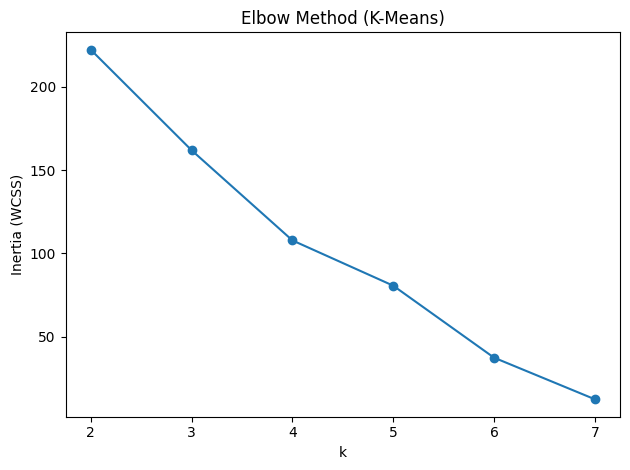

Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/figures/Unsupervised_KMeans_Elbow.png
Silhouette (KMeans): 0.526
Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/kmeans_cluster_distribution.csv
Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/kmeans_cluster_profiles.csv


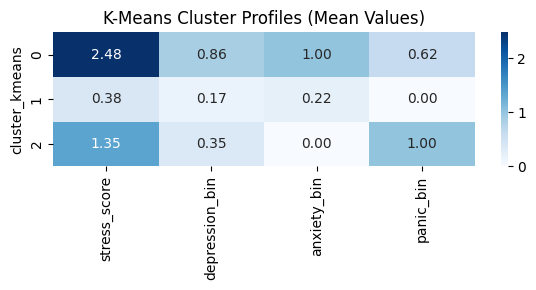

Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/figures/Unsupervised_KMeans_Profiles.png


In [17]:
# ============================================================
# BLOK 17: K-MEANS CLUSTERING
# - Elbow plot kaydet
# - KMeans fit + silhouette
# - Cluster dağılımı + profil tablolarını kaydet
# - Heatmap figür kaydet
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1) Elbow method
inertias = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method (K-Means)")
plt.tight_layout()
plt.savefig(FIG_DIR / "Unsupervised_KMeans_Elbow.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", FIG_DIR / "Unsupervised_KMeans_Elbow.png")

# 2) Final KMeans (k=3)
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(X_scaled)

sil_kmeans = silhouette_score(X_scaled, labels_km)
print("Silhouette (KMeans):", round(sil_kmeans, 3))

# 3) Kaydet: model + labels
import joblib
joblib.dump(kmeans, MODEL_DIR / "kmeans.joblib")
joblib.dump(labels_km, MODEL_DIR / "kmeans_labels.joblib")

# 4) df içine ekle
df["cluster_kmeans"] = labels_km

# 5) Cluster dağılım tablosu
kmeans_dist = df["cluster_kmeans"].value_counts().sort_index().reset_index()
kmeans_dist.columns = ["Cluster", "Count"]
kmeans_dist.to_csv(TAB_DIR / "kmeans_cluster_distribution.csv", index=False)

# 6) Cluster profile tablosu
cluster_profile_kmeans = df.groupby("cluster_kmeans")[unsup_features].mean()
cluster_profile_kmeans.to_csv(TAB_DIR / "kmeans_cluster_profiles.csv")

print("Saved:", TAB_DIR / "kmeans_cluster_distribution.csv")
print("Saved:", TAB_DIR / "kmeans_cluster_profiles.csv")

# 7) Heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(cluster_profile_kmeans, annot=True, cmap="Blues", fmt=".2f")
plt.title("K-Means Cluster Profiles (Mean Values)")
plt.tight_layout()
plt.savefig(FIG_DIR / "Unsupervised_KMeans_Profiles.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", FIG_DIR / "Unsupervised_KMeans_Profiles.png")


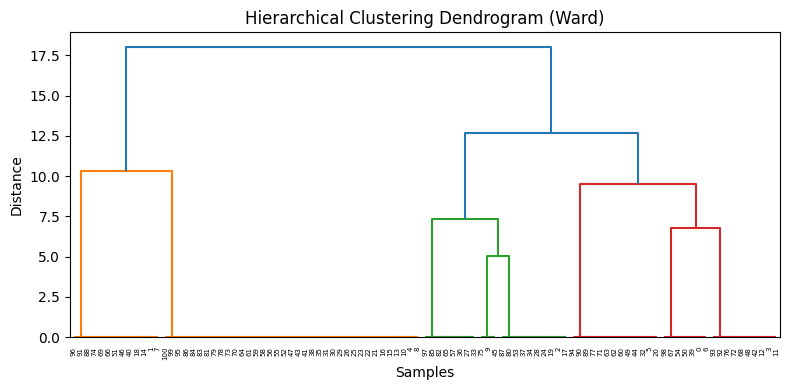

Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/figures/Unsupervised_Hierarchical_Dendrogram.png
Silhouette (Hierarchical): 0.528
Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/hierarchical_cluster_distribution.csv
Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/hierarchical_cluster_profiles.csv


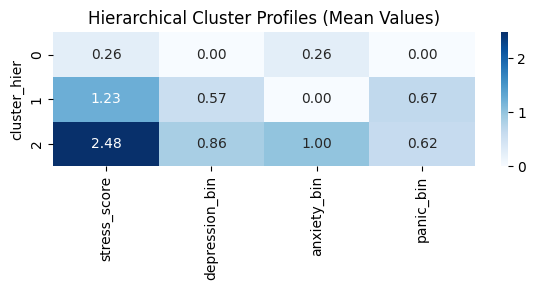

Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/figures/Unsupervised_Hierarchical_Profiles.png


In [19]:
# ============================================================
# BLOK 18: HIERARCHICAL CLUSTERING (Agglomerative)
# - Dendrogram kaydet
# - Fit + silhouette
# - Cluster dağılımı + profil tablolarını kaydet
# - Heatmap figür kaydet
# ============================================================

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# 1) Dendrogram
Z = linkage(X_scaled, method="ward")
plt.figure(figsize=(8, 4))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram (Ward)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig(FIG_DIR / "Unsupervised_Hierarchical_Dendrogram.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", FIG_DIR / "Unsupervised_Hierarchical_Dendrogram.png")

# 2) Fit (n_clusters=3)
hier = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_h = hier.fit_predict(X_scaled)

sil_hier = silhouette_score(X_scaled, labels_h)
print("Silhouette (Hierarchical):", round(sil_hier, 3))

df["cluster_hier"] = labels_h
joblib.dump(labels_h, MODEL_DIR / "hierarchical_labels.joblib")

# 3) Distribution
hier_dist = df["cluster_hier"].value_counts().sort_index().reset_index()
hier_dist.columns = ["Cluster", "Count"]
hier_dist.to_csv(TAB_DIR / "hierarchical_cluster_distribution.csv", index=False)

# 4) Profiles
cluster_profile_hier = df.groupby("cluster_hier")[unsup_features].mean()
cluster_profile_hier.to_csv(TAB_DIR / "hierarchical_cluster_profiles.csv")

print("Saved:", TAB_DIR / "hierarchical_cluster_distribution.csv")
print("Saved:", TAB_DIR / "hierarchical_cluster_profiles.csv")

# 5) Heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(cluster_profile_hier, annot=True, cmap="Blues", fmt=".2f")
plt.title("Hierarchical Cluster Profiles (Mean Values)")
plt.tight_layout()
plt.savefig(FIG_DIR / "Unsupervised_Hierarchical_Profiles.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", FIG_DIR / "Unsupervised_Hierarchical_Profiles.png")


Noise points: 3 (2.97%)
Silhouette (DBSCAN): 1.0
Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/dbscan_cluster_distribution.csv
Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/dbscan_noise_summary.csv
Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/dbscan_cluster_profiles.csv


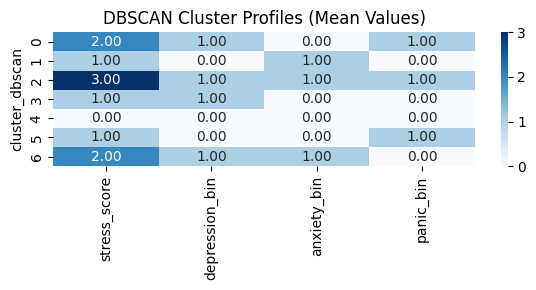

Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/figures/Unsupervised_DBSCAN_Profiles.png


In [20]:
# ============================================================
# BLOK 19: DBSCAN
# - Fit + noise ratio
# - (Varsa) silhouette
# - Distribution + profile tablolarını kaydet
# - Heatmap figür kaydet
# ============================================================

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Parametreler (senin çıktına göre ayarlayabilirsin)
eps = 0.9
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_db = dbscan.fit_predict(X_scaled)

df["cluster_dbscan"] = labels_db
joblib.dump(labels_db, MODEL_DIR / "dbscan_labels.joblib")

# Noise ratio
n_noise = (labels_db == -1).sum()
noise_ratio = n_noise / len(labels_db)
print("Noise points:", n_noise, f"({noise_ratio:.2%})")

# Silhouette (noise hariç en az 2 cluster varsa)
unique_clusters = [c for c in np.unique(labels_db) if c != -1]
if len(unique_clusters) >= 2:
    sil_dbscan = silhouette_score(X_scaled[labels_db != -1], labels_db[labels_db != -1])
    print("Silhouette (DBSCAN):", round(sil_dbscan, 3))
else:
    sil_dbscan = None
    print("Silhouette (DBSCAN): Not computed (insufficient clusters).")

# Distribution table
dbscan_dist = df["cluster_dbscan"].value_counts().sort_index().reset_index()
dbscan_dist.columns = ["Cluster", "Count"]
dbscan_dist.to_csv(TAB_DIR / "dbscan_cluster_distribution.csv", index=False)

# Noise summary table
noise_summary = pd.DataFrame([{
    "eps": eps,
    "min_samples": min_samples,
    "noise_points": int(n_noise),
    "noise_ratio": float(noise_ratio)
}])
noise_summary.to_csv(TAB_DIR / "dbscan_noise_summary.csv", index=False)

print("Saved:", TAB_DIR / "dbscan_cluster_distribution.csv")
print("Saved:", TAB_DIR / "dbscan_noise_summary.csv")

# Profiles (noise hariç)
cluster_profile_dbscan = df[df["cluster_dbscan"] != -1].groupby("cluster_dbscan")[unsup_features].mean()
cluster_profile_dbscan.to_csv(TAB_DIR / "dbscan_cluster_profiles.csv")
print("Saved:", TAB_DIR / "dbscan_cluster_profiles.csv")

# Heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(cluster_profile_dbscan, annot=True, cmap="Blues", fmt=".2f")
plt.title("DBSCAN Cluster Profiles (Mean Values)")
plt.tight_layout()
plt.savefig(FIG_DIR / "Unsupervised_DBSCAN_Profiles.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", FIG_DIR / "Unsupervised_DBSCAN_Profiles.png")


In [21]:
# ============================================================
# BLOK 20: UNSUPERVISED MODEL COMPARISON TABLE
# ============================================================

comparison_rows = [
    {
        "Method": "K-Means",
        "Clusters": df["cluster_kmeans"].nunique(),
        "Silhouette": float(sil_kmeans),
        "Noise Detected": "No",
        "Interpretability": "Moderate"
    },
    {
        "Method": "Hierarchical",
        "Clusters": df["cluster_hier"].nunique(),
        "Silhouette": float(sil_hier),
        "Noise Detected": "No",
        "Interpretability": "High"
    },
    {
        "Method": "DBSCAN",
        "Clusters": len([c for c in df["cluster_dbscan"].unique() if c != -1]),
        "Silhouette": (float(sil_dbscan) if sil_dbscan is not None else np.nan),
        "Noise Detected": f"Yes ({noise_ratio:.0%})",
        "Interpretability": "Low"
    }
]

comparison_df = pd.DataFrame(comparison_rows)
print(comparison_df)

comparison_df.to_csv(TAB_DIR / "unsupervised_model_comparison.csv", index=False)
print("Saved:", TAB_DIR / "unsupervised_model_comparison.csv")


         Method  Clusters  Silhouette Noise Detected Interpretability
0       K-Means         3    0.525997             No         Moderate
1  Hierarchical         3    0.528438             No             High
2        DBSCAN         7    1.000000       Yes (3%)              Low
Saved: /content/drive/MyDrive/Student-Stress-Academic-Performance/outputs/tables/unsupervised_model_comparison.csv
